In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import monad
import scipy.stats
import nve_basic
import gsd.hoomd
import ghalton
import itertools
import scipy.spatial
reload(monad)


Input parameters
Number of particles 256
Initial temperature 1.00000000e+00
Box size 5.30000000e+00
epsilon 1.00000000e+00
sigma 1.00000000e+00
dt 5.00000000e-03
Total time 1.00000000e+02
Number of steps 20000


<module 'monad' from 'monad.pyc'>

Numpy vectorization approach adapted from https://www.labri.fr/perso/nrougier/from-python-to-numpy/#boids

### Begin with a 2D LJ simulation

This will be a 2-dimensional simulation of Lennard-Jones particles using all dimensionless parameters:
* Time step $t = 1$
* Particle mass $m = 1$
* Temperature $T = 1$
* LJ potential width $\sigma=1$
* LJ potential depth $\epsilon=1$

In [2]:
# Define simulation settings
n = 16
L = 10.  # Simulation box size
sigma = 1.
epsilon = 1.
rcut = 20.
nlog = 10 # Log to trajectory every dtlog time steps
dt = .5

In [3]:
# pos = nve_basic.fcc_positions(n, L)
gh = ghalton.Halton(3)
pos = np.array(gh.get(256))

(0, 1)

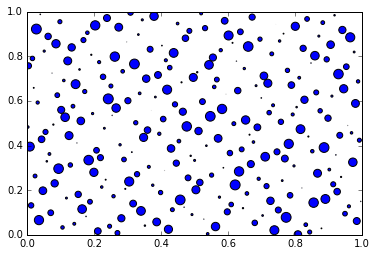

In [4]:
# Visualize uniform initial positions in simulation box
plt.scatter(pos[:,0], pos[:,1], s=pos[:,2]**2 * 100)
plt.xlim(0,1)
plt.ylim(0,1)

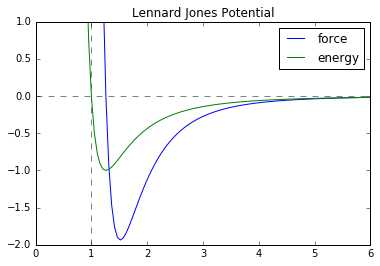

In [5]:
x = np.linspace(.9, 6, 100)
force = monad.lj(x, 1, 1)[0]
energy = monad.lj(x, 1, 1)[1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, force, label='force')
ax.plot(x, energy, label='energy')
ax.hlines(0, 0, 6, color = 'gray', linestyle='--')
ax.vlines(1, -2, 1, color = 'gray', linestyle='--')
ax.set_title('Lennard Jones Potential')
ax.set_ylim(-2,1)
ax.legend()

In [104]:
%%time
# Initialize and run trajectory
nframes = int(1e3)
dt = .0001
nlog=10
n = 200
L = 50
# gh = ghalton.Halton(3)
# init_pos = np.array(gh.get(n)) * L - (L/2)  # Initialize in quasirandom for gas/liquid
init_pos = nve_basic.fcc_positions(n, L) * L - (L/2)  # Initialize as FCC for solid
init_vel = monad.initialize_velocities(n) * 0.
ptraj, vtraj, etraj = monad.run(init_pos.copy(), init_vel.copy(), L, nframes=nframes, nlog=nlog, dt=dt)

CPU times: user 13.8 s, sys: 8 ms, total: 13.8 s
Wall time: 13.8 s


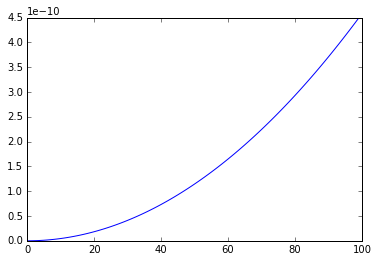

In [105]:
kinetic_energy = np.sum(vtraj**2, axis=(1,2))
plt.plot(kinetic_energy)

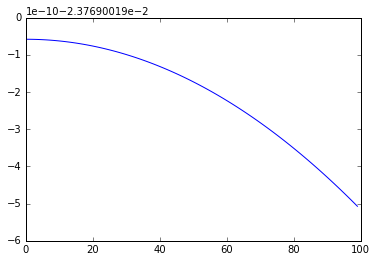

In [106]:
plt.plot(etraj)

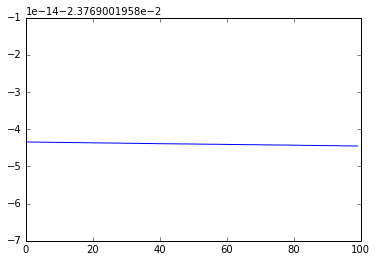

In [107]:
plt.plot(etraj + kinetic_energy)

In [96]:
etraj[0]

53326991.601954676

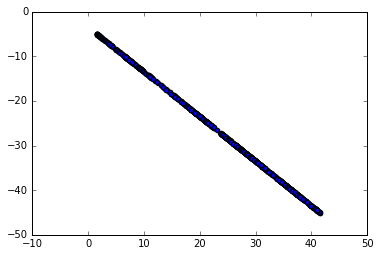

In [217]:
plt.scatter(kinetic_energy, etraj)

In [218]:
scipy.stats.linregress(kinetic_energy, etraj)

LinregressResult(slope=-1.0008513836477324, intercept=-3.4727713069720068, rvalue=-0.99999991634016039, pvalue=0.0, stderr=1.2959190145940882e-05)

## Visualize the trajectory

In [237]:
def create_frame(frame):
    s = gsd.hoomd.Snapshot()
    s.configuration.step = i
    s.particles.N = len(frame)
    s.particles.position = frame
    s.particles.diameter = np.ones(len(frame)) * .1
    return s

In [238]:
def write_gsd(f, ptraj, vtraj, sigma, L):
    fd = gsd.hoomd.open(name=f, mode='wb')
    for i in range(len(ptraj)):
        frame = ptraj[i]
        vframe = vtraj[i]
        fd.append(create_frame(frame))

In [239]:
write_gsd('test.gsd', ptraj, vtraj, sigma, L)

In [80]:
fd = open('test.txt', 'w')
fd.write()

In [91]:
def write_xyz(f, ptraj):
    with open(f, 'wb') as fd:
        fd.write(str(len(ptraj)) + '\n')
        fd.write('\n')
        for vec in ptraj:
            fd.write('Ar {}\n'.format('  '.join([str(x) for x in vec])))

In [92]:
write_xyz('test.xyz', ptraj)

In [ ]:
nve_basic.create_frame(ptraj, vtraj, sigma, L, frame):

In [76]:
%%bash 
rm f/lj/*.png

In [77]:
def write_frames(ptraj, start=0, stop=None, stride=1, dpi=100):
    if stop is None:
        stop = len(ptraj)
    for count, frameid in enumerate(range(start, stop, stride)):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(*ptraj[frameid].T)
        ax.set_xlim(-L/2, L/2)
        ax.set_ylim(-L/2, L/2)
        fig.savefig('f/lj/{}.png'.format(count), dpi=100, bbox_inches='tight')
        plt.close(fig)    

In [78]:
write_frames(ptraj, 0, None, 5, dpi=50)

/home/chargus/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:806: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


In [134]:
%%bash
ffmpeg -framerate 15 -i f/lj/%d.png f/lj/out.mp4 -y  -loglevel error

<video controls src="f/lj/out.mp4" />

## Convergence testing on $\Delta t$

In [2]:
nve_basic.fcc_positions(200, 10)

array([[ 0.05,  0.05,  0.05],
       [ 0.05,  0.15,  0.15],
       [ 0.15,  0.15,  0.05],
       [ 0.15,  0.05,  0.15],
       [ 0.05,  0.05,  0.25],
       [ 0.05,  0.15,  0.35],
       [ 0.15,  0.15,  0.25],
       [ 0.15,  0.05,  0.35],
       [ 0.05,  0.05,  0.45],
       [ 0.05,  0.15,  0.55],
       [ 0.15,  0.15,  0.45],
       [ 0.15,  0.05,  0.55],
       [ 0.05,  0.05,  0.65],
       [ 0.05,  0.15,  0.75],
       [ 0.15,  0.15,  0.65],
       [ 0.15,  0.05,  0.75],
       [ 0.05,  0.25,  0.05],
       [ 0.05,  0.35,  0.15],
       [ 0.15,  0.35,  0.05],
       [ 0.15,  0.25,  0.15],
       [ 0.05,  0.25,  0.25],
       [ 0.05,  0.35,  0.35],
       [ 0.15,  0.35,  0.25],
       [ 0.15,  0.25,  0.35],
       [ 0.05,  0.25,  0.45],
       [ 0.05,  0.35,  0.55],
       [ 0.15,  0.35,  0.45],
       [ 0.15,  0.25,  0.55],
       [ 0.05,  0.25,  0.65],
       [ 0.05,  0.35,  0.75],
       [ 0.15,  0.35,  0.65],
       [ 0.15,  0.25,  0.75],
       [ 0.05,  0.45,  0.05],
       [ 0

## Calculate g(r)

In [ ]:
def g_of_r()

### Run another simulation with fewer particles and larger width ($\sigma$)

In [139]:
# Repeat with particles of larger width (sigma)
n = 16
L = 60.  # Simulation box size
sigma = 4
epsilon = 1.
rcut = 20.
dtlog = 10 # Log to trajectory every dtlog time steps
init_pos = monad.initialize_positions(n, L)
init_vel = monad.initialize_velocities(n, .1)
traj, vetraj, ketraj = monad.run(init_pos, init_vel, L, nframes=5000, dtlog=10, rcut=20, sigma=sigma, epsilon=epsilon)

In [140]:
%%bash 
rm f/biglj/*.png

In [141]:
for i in range(0,300):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(*traj[i].T)
    ax.set_xlim(-L/2, L/2)
    ax.set_ylim(-L/2, L/2)
    fig.savefig('f/biglj/{}.png'.format(i), dpi=100, bbox_inches='tight')
    plt.close(fig)

In [142]:
%%bash
ffmpeg -framerate 25 -i f/biglj/%d.png f/biglj/out.mp4 -y  -loglevel error

<video controls src="f/biglj/out.mp4" />